from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [2]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [ ]:
filenames = ['Confirmed', 'Deaths', 'Recovered']
base_url = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series'



In [7]:
#hide

import os

os.environ['NO_PROXY'] = 'raw.githubusercontent.com'

def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    # Thanks to kasparthommen for the suggestion to directly downloadCSSEGISandData
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    print(url)
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

df_confirmed = load_timeseries('Confirmed')

# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

# Compute days relative to when 100 confirmed cases was crossed
df_confirmed.loc[:, 'days_since_100'] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_100'] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < 100)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= 100)]))
    
annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df_confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


In [9]:
df_confirmed

,country,state,type,cases,cases_crit,days_since_100
date,,,,,,
2020-01-22,Thailand,NaN,confirmed,2,0.10,-53.0
2020-01-23,Thailand,NaN,confirmed,3,0.15,-52.0
2020-01-24,Thailand,NaN,confirmed,5,0.25,-51.0
2020-01-25,Thailand,NaN,confirmed,7,0.35,-50.0
2020-01-26,Thailand,NaN,confirmed,8,0.40,-49.0
...,...,...,...,...,...,...
2020-03-12,United Kingdom (total),NaN,confirmed,459,22.95,7.0
2020-03-13,United Kingdom (total),NaN,confirmed,802,40.10,8.0
2020-03-14,United Kingdom (total),NaN,confirmed,1144,57.20,9.0


In [10]:
#hide
# Country names seem to change quite a bit
df_confirmed.country.unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

In [11]:
#hide
european_countries = ['Italy', 'Germany', 'France (total)', 'Spain', 'United Kingdom (total)', 
                      'Iran']
large_engl_countries = ['US (total)', 'Canada (total)', 'Australia (total)']
asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong']
south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

country_groups = [european_countries, large_engl_countries, asian_countries, south_american_countries]
line_styles = ['-', ':', '--', '-.']

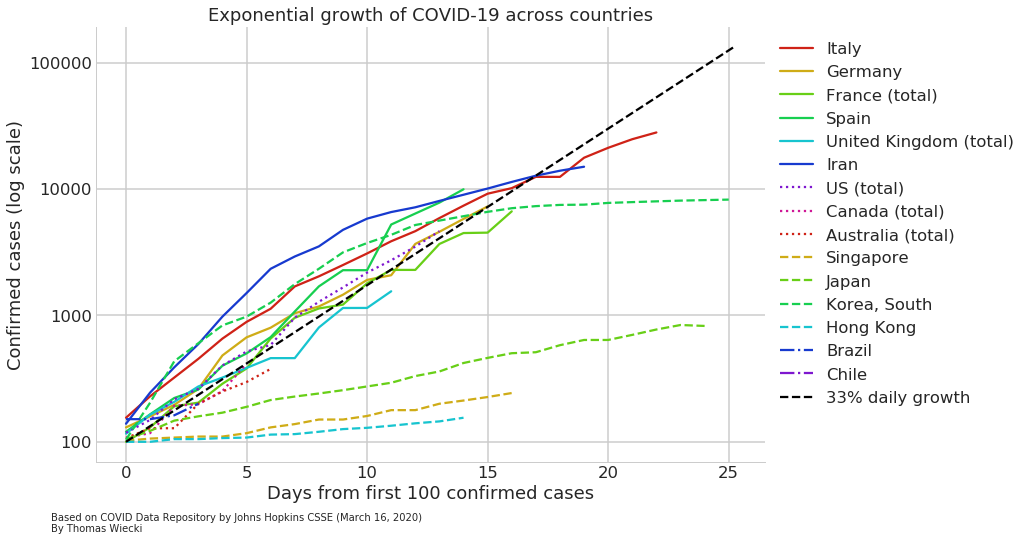

In [12]:
#collapse-hide

def plot_countries(df, countries, min_cases=100, ls='-', col='cases'):
    for country in countries:
        df_country = df.loc[(df.country == country) & (df.cases >= min_cases)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)
        
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(yscale='log',
       title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

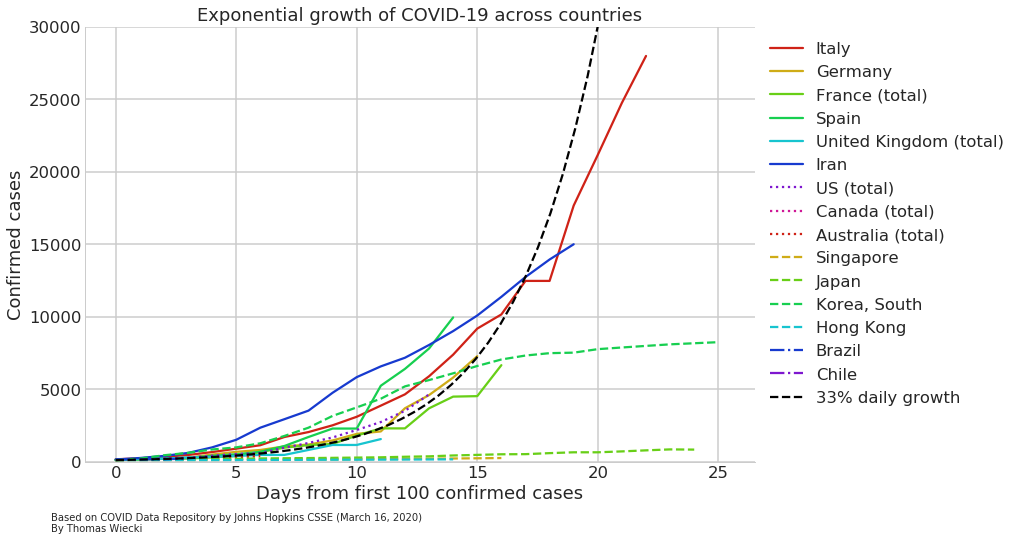

In [13]:
#collapse-hide
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases', ylim=(0, 30000))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

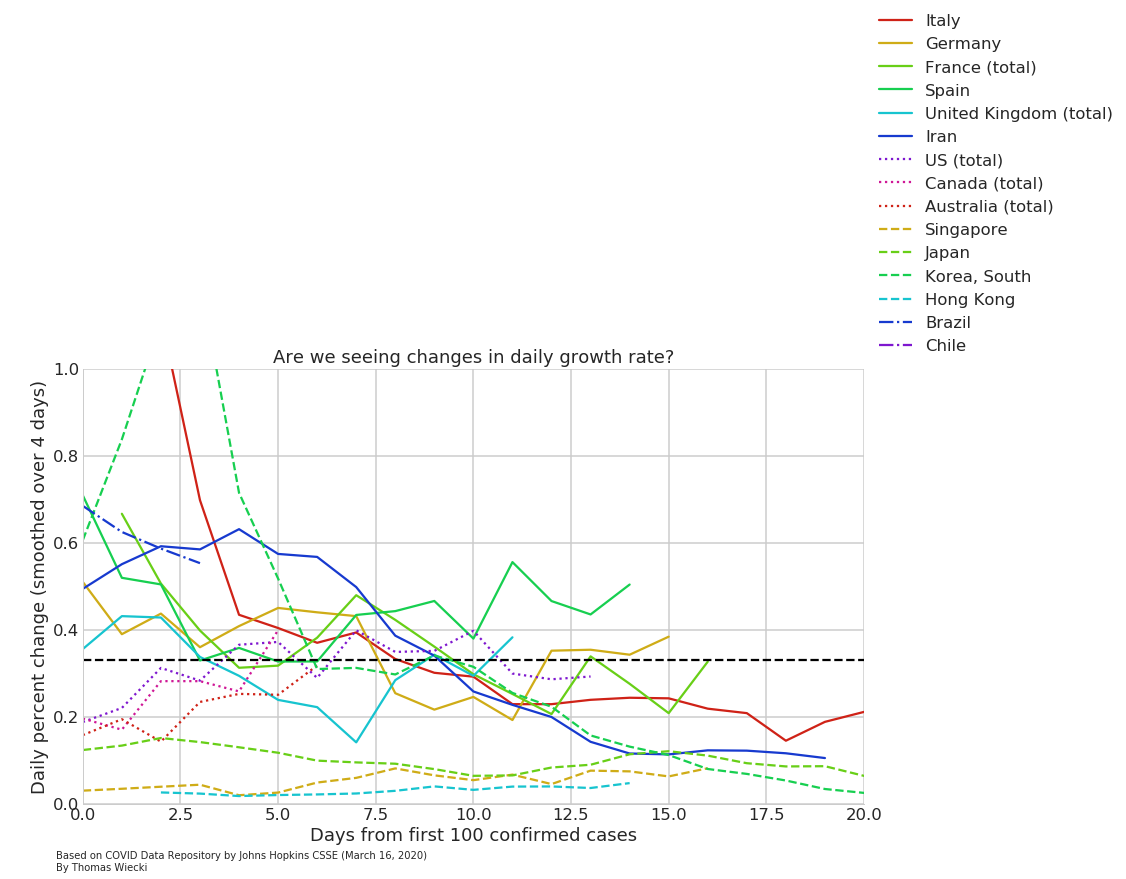

In [14]:
#collapse-hide
smooth_days = 4
fig, ax = plt.subplots(figsize=(14, 8))
df_confirmed['pct_change'] = (df_confirmed
                              .groupby('country')
                              .cases
                              .pct_change()
                              .rolling(smooth_days)
                              .mean()
)

for countries, ls in zip(country_groups, line_styles):
    (df_confirmed.set_index('country')
                 .loc[countries]
                 .loc[lambda x: x.cases > 100]
                 .reset_index()
                 .set_index('days_since_100')
                 .groupby('country', sort=False)['pct_change']
                 .plot(ls=ls)
    )

ax.set(ylim=(0, 1),
       xlim=(0, 20),
       title='Are we seeing changes in daily growth rate?',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Daily percent change (smoothed over {} days)'.format(smooth_days),
)
ax.axhline(.33, ls='--', color='k')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

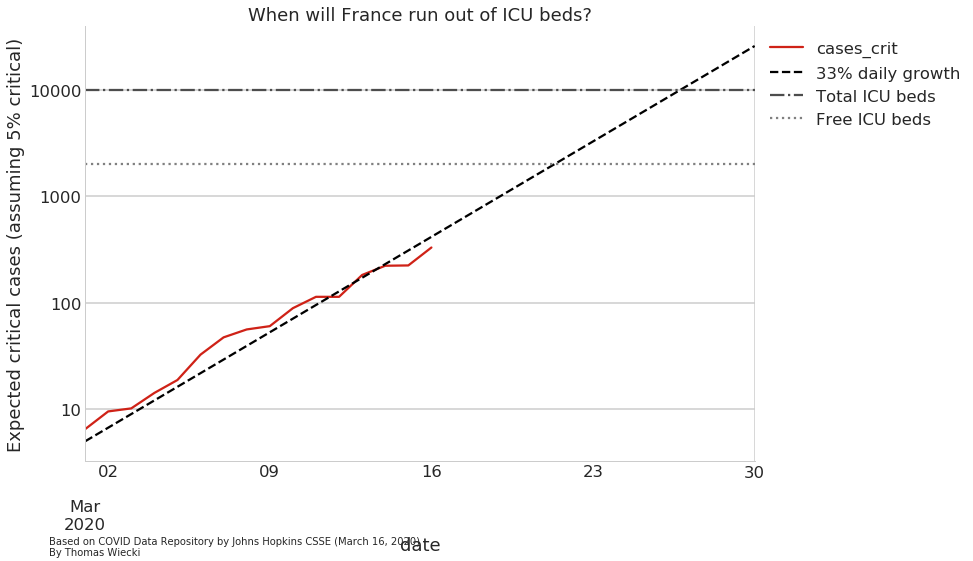

In [15]:
#collapse-hide
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

# 5000 ICU beds total, 80% occupied
# source https://www.lesechos.fr/industrie-services/pharmacie-sante/coronavirus-comment-les-fabricants-de-respirateurs-artificiels-se-plient-en-quatre-1185393

icu_germany = 28000
icu_germany_free = .2
icu_france = 10000 #aujourd'hui 5000, volonté d'étendre à 15000. Je coupe en 2
icu_france_free = .2 #situation Allemagne


df_tmp = df_confirmed.loc[lambda x: (x.country == 'France') & (x.cases > 100)].cases_crit
df_tmp.plot(ax=ax)

x = np.linspace(0, 30, 30)
pd.Series(index=pd.date_range(df_tmp.index[0], periods=30),
          data=100*p_crit * (1.33) ** x).plot(ax=ax,ls='--', color='k', label='33% daily growth')

ax.axhline(icu_france, color='.3', ls='-.', label='Total ICU beds')
ax.axhline(icu_france * icu_france_free, color='.5', ls=':', label='Free ICU beds')
ax.set(yscale='log',
       title='When will France run out of ICU beds?',
       ylabel='Expected critical cases (assuming {:.0f}% critical)'.format(100 * p_crit),
)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);